# Objective: 

The primary objective of this project is to :

* develop accurate forecasts of cash withdrawals for four distinct ATM machines during the month of May 2010. 
     
* develop forecasts of residential power consumption for the year 2014

# Deliverables: 

* <u>Report</u>: documenting the data exploration findings, the rationale behind the chosen modeling techniques, the evaluation metrics employed, and a discussion of the final forecasts with accompanying visualizations.

* <u>Excel File</u>: containing the final cash withdrawal forecasts in a clear, accessible format

In [1]:
#| echo : false 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pd.set_option('display.max_columns', 10)
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
#| echo : false

# read in excel file
atm_df = pd.read_excel('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/project_1/data_files/ATM624Data.xlsx', parse_dates=['DATE'], index_col= 'DATE')

# Part A : ATM Data

## Exploratory Data Analysis / Data Cleaning

ATM data has four unique ATMs and a Cash column that represents the amount of cash taken out in the day in hundreds of dollars. For instance, ATM1 on 2009-05-01 had $9600 taken out.

In [3]:
#| echo : false

from statsmodels.tsa.stattools import adfuller, kpss
# using the augmented dicky fuller test 
def adfuller_test(series) : 
     result = adfuller(series)
     print('ADF Statistic: %f' % result[0]) # the more negative this value is the more likely ts is stationary
     print('p-value: %f' % result[1])       # if p-values is less than 0.05 we reject the null: ts is non-stationary
     print('Critical Values:')
     for key, value in result[4].items():
          print('\t%s: %.3f' % (key, value))
     print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

In [4]:
# show data
atm_df

,ATM,Cash
DATE,,
2009-05-01,ATM1,96.000000
2009-05-01,ATM2,107.000000
2009-05-02,ATM1,82.000000
2009-05-02,ATM2,89.000000
2009-05-03,ATM1,85.000000
...,...,...
2010-04-26,ATM4,403.839336
2010-04-27,ATM4,13.697331
2010-04-28,ATM4,348.201061


Our data has 1484 observations and two columns of the `Cash` amount and the `ATM`. We notice that there are missing values in our data. We have 14 missing ATMs and 19 missing cash amounts. We will do the following:

* Remove the missing ATMs since without additional information such as location, guessing which ATMs is which is not feasible. 

* Impute the missing Cash amount by ATM meaning we first groupby ATMs 1,2,3 and 4 then aggregate the mean of each subgroup. Afterwards, if that subgroup has missingness then we impute by the mean of their respectives group.

Notice, the statistical summary of each ATMs are unique which suggest that we should treat these ATMs are independent from each other.

In [5]:
atm_df.groupby('ATM')['Cash'].describe()

,count,mean,std,min,25%,50%,75%,max
ATM,,,,,,,,
ATM1,362.0,83.886740,36.656539,1.00000,73.000000,91.000000,108.000000,180.000000
ATM2,363.0,62.578512,38.898455,0.00000,25.500000,67.000000,93.000000,147.000000
ATM3,365.0,0.720548,7.944778,0.00000,0.000000,0.000000,0.000000,96.000000
ATM4,365.0,474.043345,650.935991,1.56326,124.334415,403.839336,704.507042,10919.761638


In [6]:
#| echo : false

def show_summary(df) :
    
    print(80 * "+")
    print(f"DIMENSIONS : ({df.shape[0]}, {df.shape[1]})")
    
    print(80 * "+")
    print("COLUMNS: \n")
    print(df.columns.values)
    
    print(80 * "+")
    print("DATA INFO: \n")
    print(df.dtypes)
    
    print(80 * "+")
    print("MISSING VALUES: \n")
    print(df.isnull().sum())
    
    print(80 * "+")
    print("NUMBER OF UNIQUE VALUES: \n")
    print(df.nunique())


show_summary(atm_df)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DIMENSIONS : (1474, 2)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
COLUMNS: 

['ATM' 'Cash']
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATA INFO: 

ATM      object
Cash    float64
dtype: object
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
MISSING VALUES: 

ATM     14
Cash    19
dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NUMBER OF UNIQUE VALUES: 

ATM       4
Cash    509
dtype: int64


In [7]:
#| echo : false

def atm_fill_na(df, atm) : 

     df_atm = df.query('ATM == @atm')

     if df['Cash'].isna().any() :
          df_mean = df_atm['Cash'].mean()
          df_atm['Cash'].fillna(value = df_mean, inplace = True)
     
     return df_atm

In [8]:
#| warning : false
#| message : false
#| echo : false

atm1 = atm_fill_na(atm_df, 'ATM1')
atm2 = atm_fill_na(atm_df, 'ATM2')
atm3 = atm_fill_na(atm_df, 'ATM3')
atm4 = atm_fill_na(atm_df, 'ATM4')

C:\Users\nickc\AppData\Local\Temp\ipykernel_34840\3363021100.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atm['Cash'].fillna(value = df_mean, inplace = True)


Here, we have the visualization of each ATM to better understand its patterns. ATM4 shows a farawayoutlier where we will consider removal or some imputation.

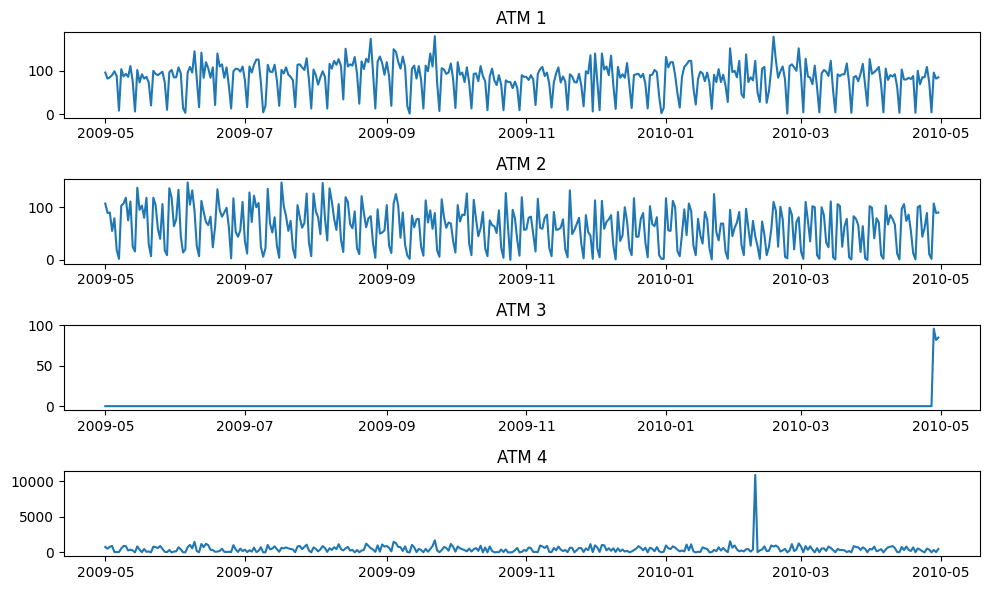

In [9]:
fig, ax = plt.subplots(4,1)
ax[0].plot(atm1.index, atm1['Cash'])
ax[0].set_title('ATM 1')

ax[1].plot(atm2.index, atm2['Cash'])
ax[1].set_title('ATM 2')

ax[2].plot(atm3.index, atm3['Cash'])
ax[2].set_title('ATM 3')

ax[3].plot(atm4.index, atm4['Cash'])
ax[3].set_title('ATM 4')

plt.tight_layout()
plt.show()

### ATM 1

ATM 1 has an average withdrawal amount $8 300 per day and the highest amount withdrawn in a day was $18 000.

ATM 1 peaks during the summer and winter months. For ARIMA models, ATM 1's is already stationary so we will not need to difference it when building an SARIMA model. It has weekly seasonality as confirmed by the AFC plot which is indicates that a SARIMA model is appropriate to use.

In [10]:
atm1.describe().T

,count,mean,std,min,25%,50%,75%,max
Cash,365.0,83.88674,36.505169,1.0,73.0,90.0,108.0,180.0


In [11]:
adfuller_test(atm1.Cash)

ADF Statistic: -3.110510
p-value: 0.025785
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Result: The series is stationary


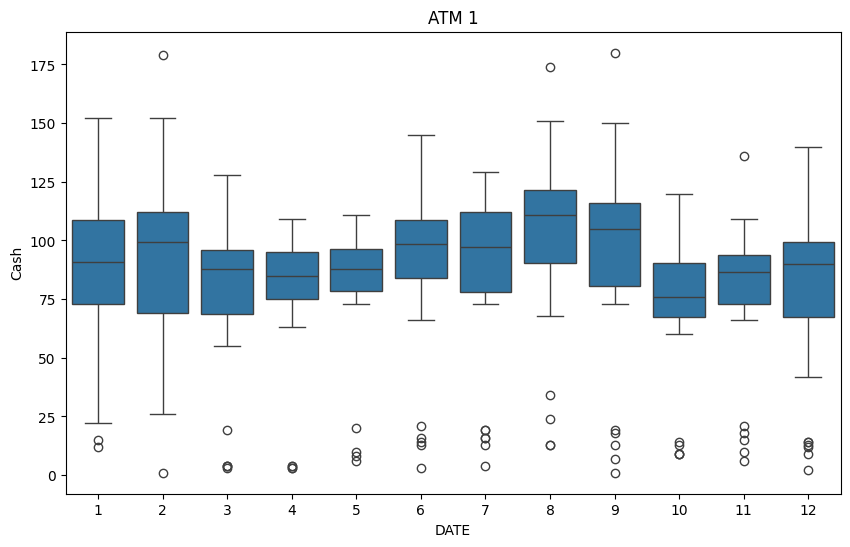

In [12]:
sns.boxplot(data = atm1, x = atm1.index.month, y = 'Cash')
plt.title('ATM 1')
plt.show()

In [13]:
#|echo : false

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

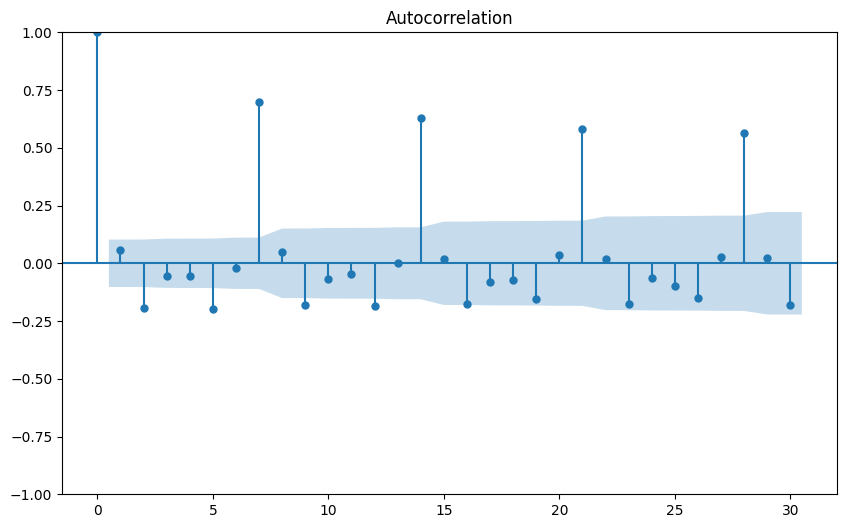

In [14]:
plot_acf(atm1['Cash'], lags=30)
plt.show()

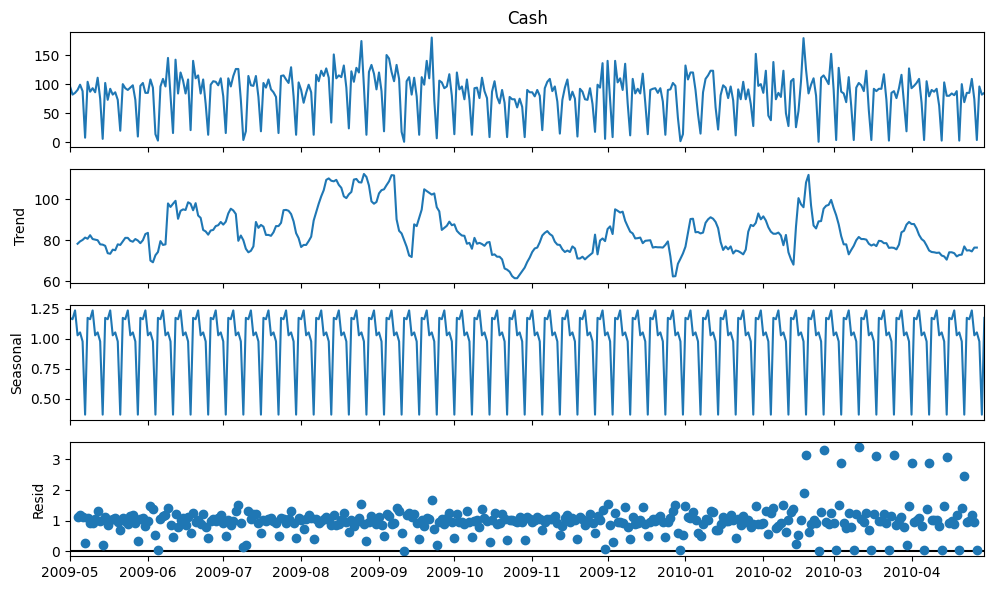

In [15]:
seasonal_decompose(atm1['Cash'], model = 'mul', period=7).plot()
plt.show()

### ATM 2

Here, we have an average withdrawlal of $6200 and a max of $14 700. Unlike ATM 1, ATM 2 does not have stationary data so some order of differencing is needed. 

In [16]:
atm2.describe().T

,count,mean,std,min,25%,50%,75%,max
Cash,365.0,62.578512,38.791444,0.0,26.0,66.0,93.0,147.0


In [17]:
adfuller_test(atm2.Cash)

ADF Statistic: -2.588113
p-value: 0.095479
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Result: The series is not stationary


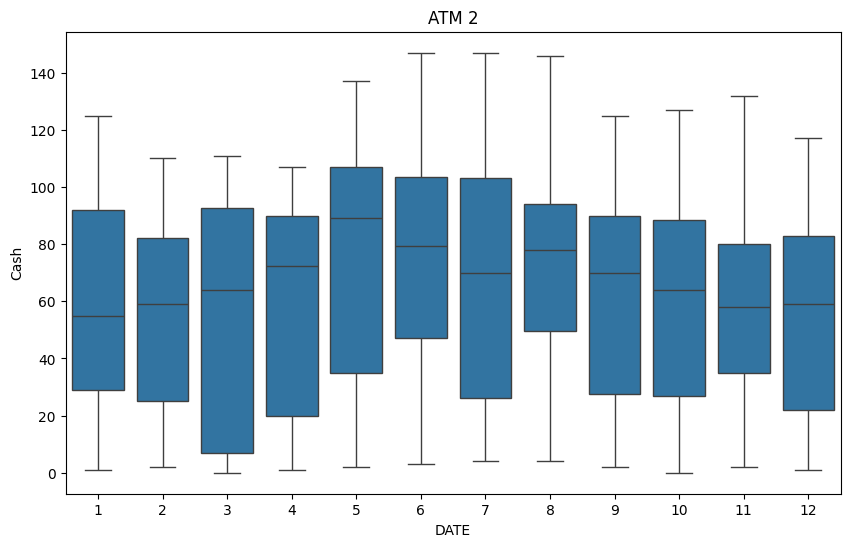

In [18]:
sns.boxplot(data = atm2, x = atm2.index.month, y = 'Cash')
plt.title('ATM 2')
plt.show()

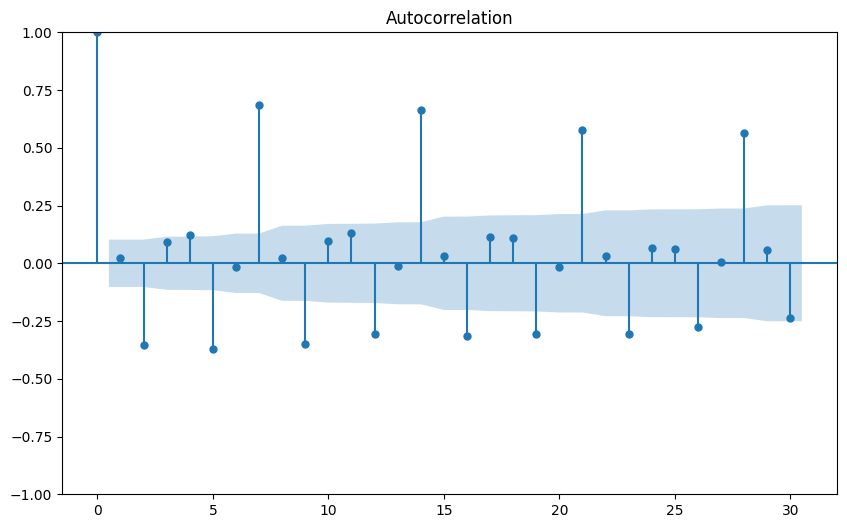

In [19]:
plot_acf(atm2['Cash'], lags=30)
plt.show()

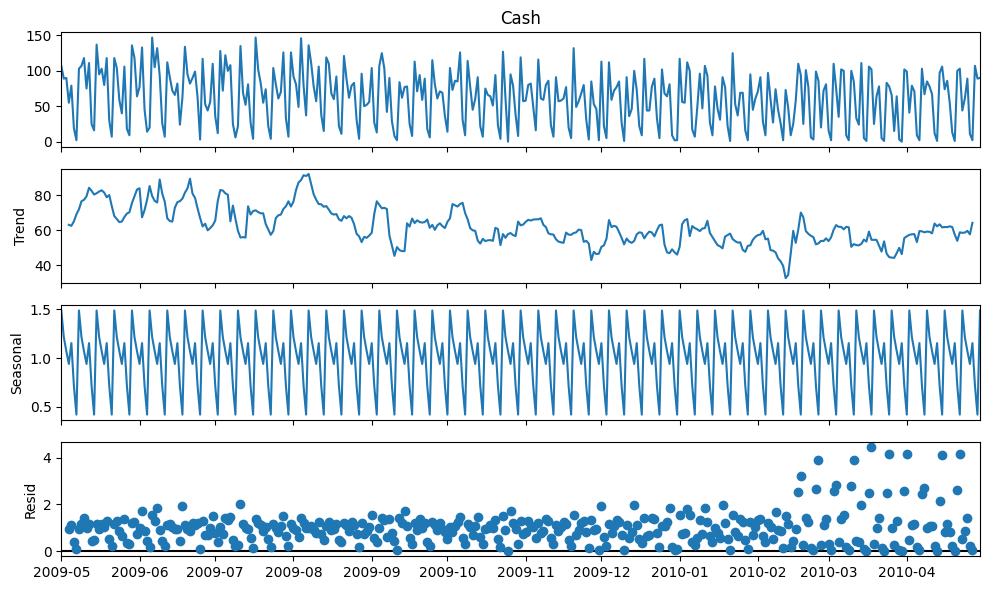

In [20]:
seasonal_decompose(atm2['Cash'] + 0.0001, model = 'mul', period=7).plot()
plt.show()

### ATM 3 

ATM 3 recorda almost zero withdrawals from the past year. It could be due to very low traffic in its location or the machine was broken. The last three records of the data are the only non-zero values. Using the data from this ATM is not enough to use for statistical learning. 

In [21]:
atm3.query('Cash > 0')

,ATM,Cash
DATE,,
2010-04-28,ATM3,96.0
2010-04-29,ATM3,82.0
2010-04-30,ATM3,85.0


In [22]:
atm3.describe().T

,count,mean,std,min,25%,50%,75%,max
Cash,365.0,0.720548,7.944778,0.0,0.0,0.0,0.0,96.0


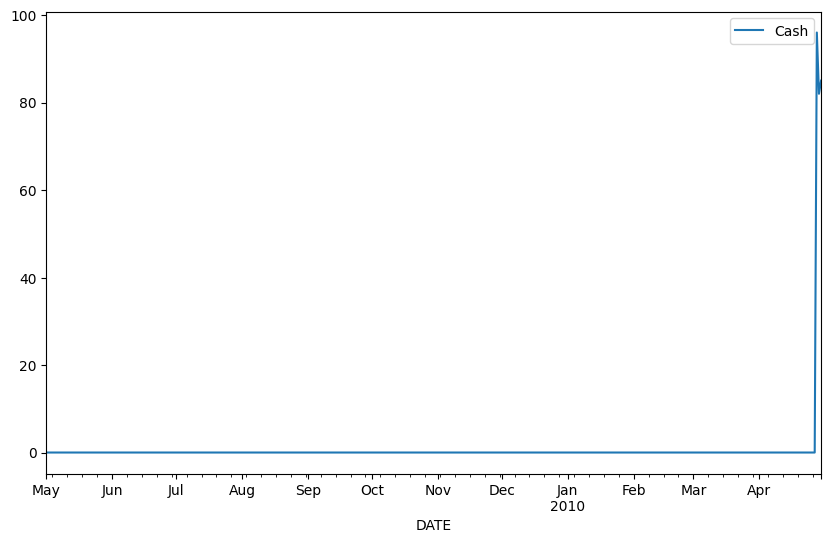

In [23]:
atm3.plot()
plt.show()

In [24]:
adfuller_test(atm2.Cash)

ADF Statistic: -2.588113
p-value: 0.095479
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Result: The series is not stationary


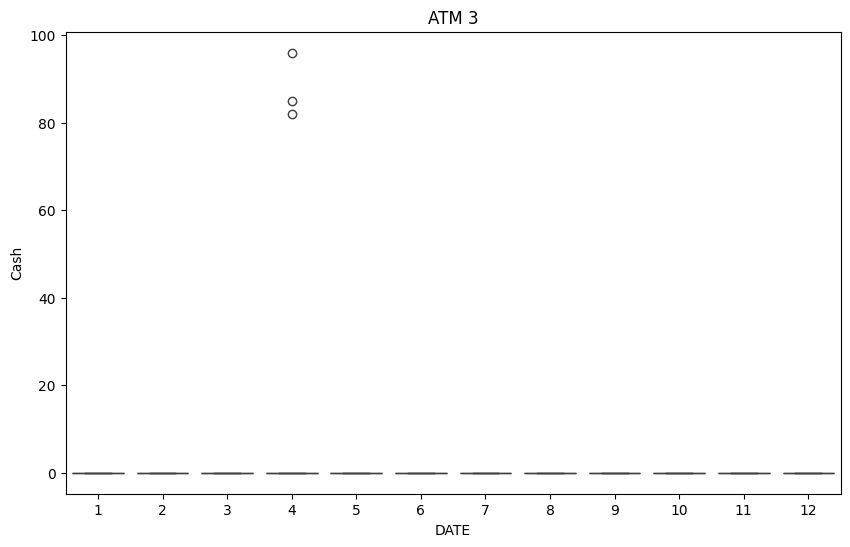

In [25]:
sns.boxplot(data = atm3, x = atm3.index.month, y = 'Cash')
plt.title('ATM 3')
plt.show()

### ATM 4

ATM 4 has an extreme outlier where we will impute with the second value of the time series because we want to keep that attribute of that day having a high cash withdrawal.

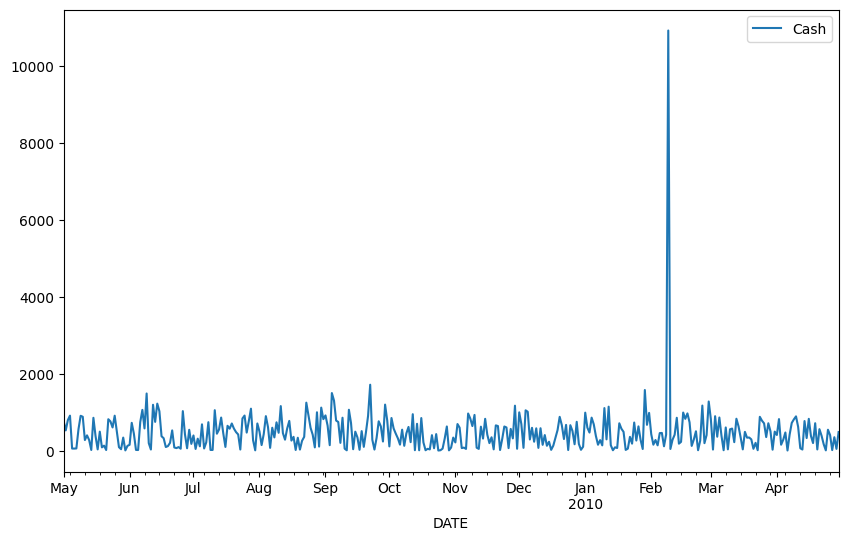

In [26]:
atm4.plot()
plt.show()

In [27]:
atm4_filtered = atm4[atm4.index != '2010-02-09']

atm4_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
Cash,364.0,445.346317,351.386229,1.56326,123.917747,403.304865,704.27077,1712.074986


In [28]:
atm4_filtered[atm4_filtered.index.month == 2].max()

ATM            ATM4
Cash    1275.968167
dtype: object

In [29]:
# replace the outlier with the second highest value in the month of Feb
atm4.loc['2010-02-09','Cash'] = 1275.968167

<Axes: xlabel='DATE'>

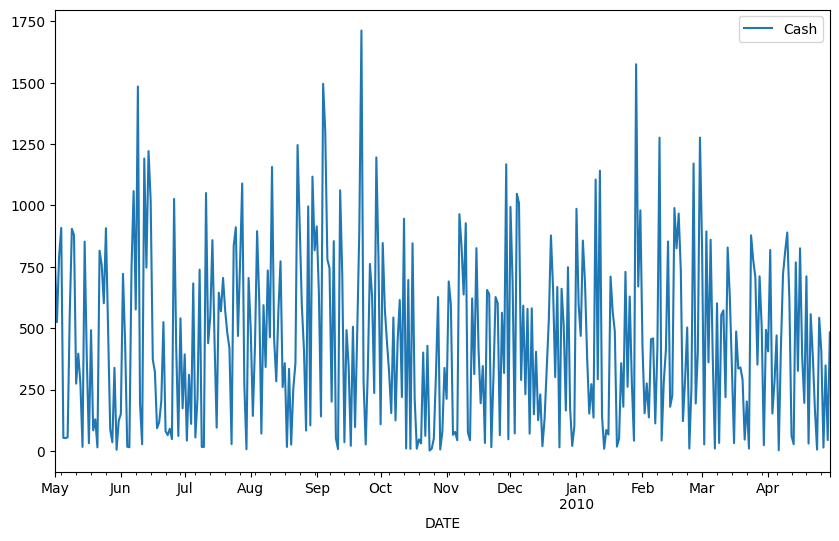

In [30]:
atm4.plot()

In [31]:
adfuller_test(atm4['Cash'])

ADF Statistic: -6.149210
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Result: The series is stationary


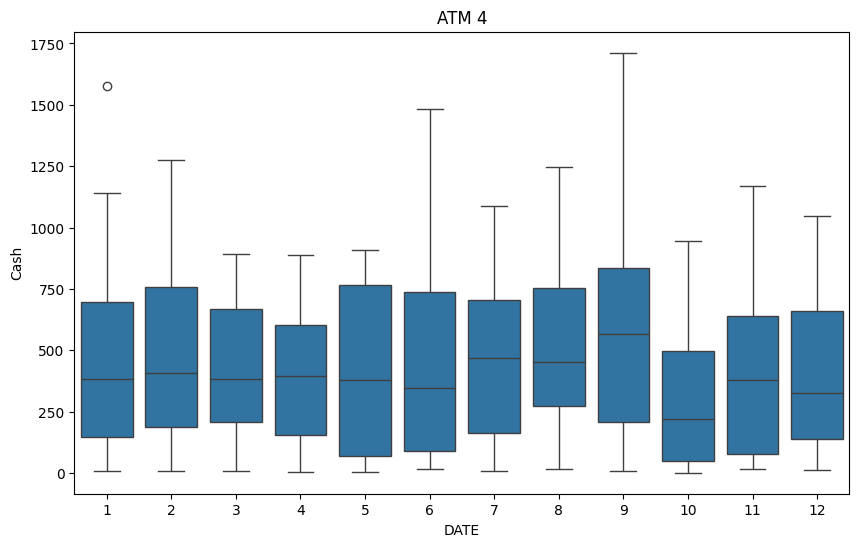

In [32]:
sns.boxplot(data = atm4, x = atm4.index.month, y = 'Cash')
plt.title('ATM 4')
plt.show()

***

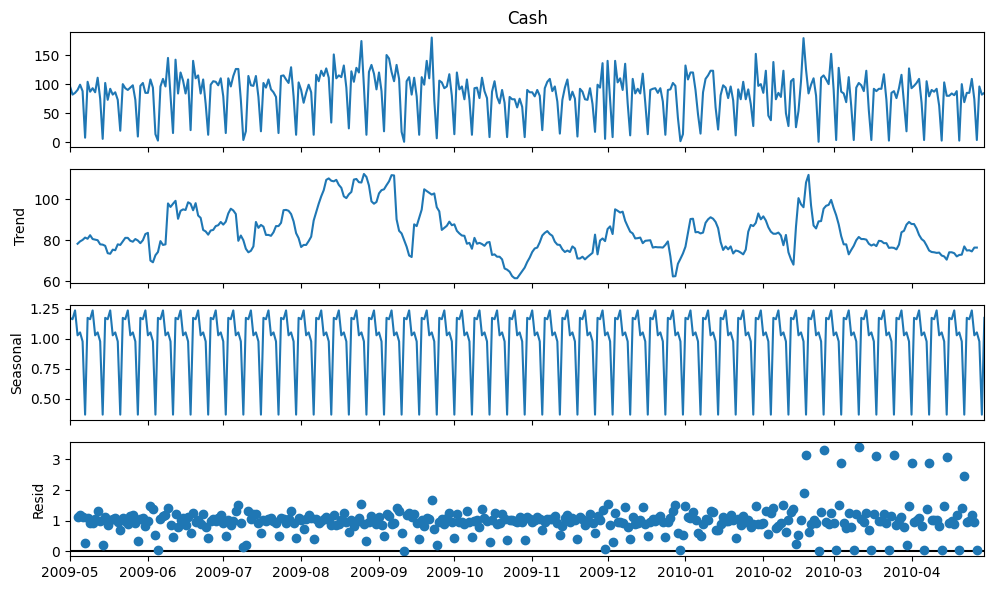

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(atm1['Cash'], model = 'mul', period=7).plot()
plt.show()

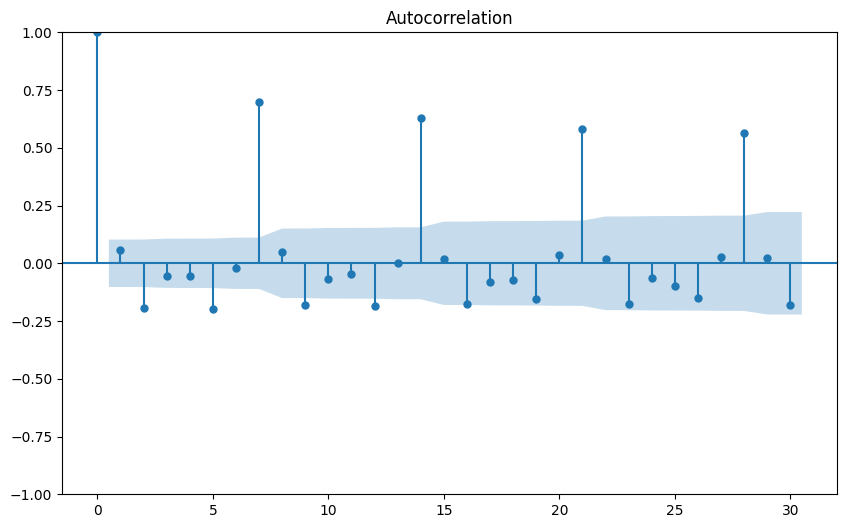

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(atm1['Cash'], lags=30)
plt.show()

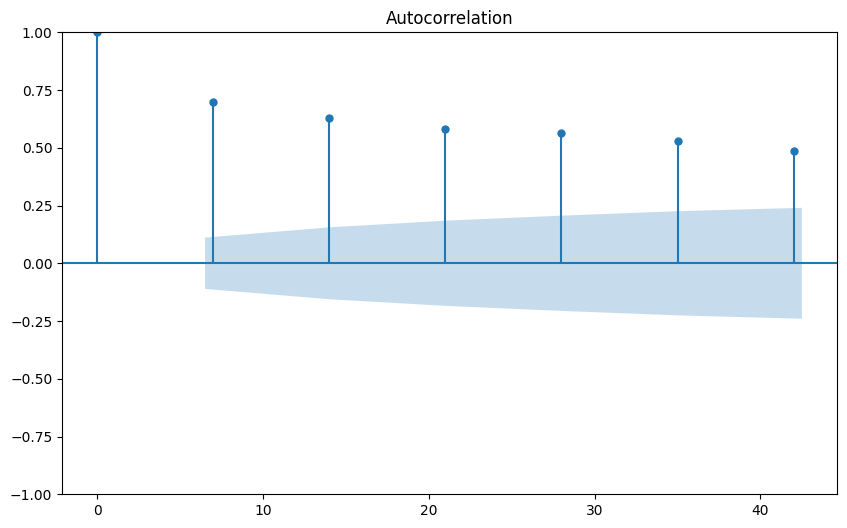

In [35]:
plot_acf(atm1['Cash'], lags=[0,7,14,21,28,35,42])
plt.show()

## Model Building and Selection

In this section, we will create SARIMA models and Exponential Smoothing models such as the simple exponential smoothing, Holt's Exponential and Holt-Winters models. The performance metrics we will use are RMSE, MSE, and MAE. Moreover, we use rolling window time series cross validation so that the test data is always the future values from the training set. For ATM 1,2, and 4 we will use there methods to find the best model to forecast May 2010. 

For ATM 3, recall that out of 365 observations, only the last three values were non-zeros. Therefore, due to the lack of non-zero data we will forecast ATM3 with a Naive approach. ATM3 distribution represents a degenerate distribution which is difficult for a training model to learn from. 

We created two functions to streamline the model building process:

     * `arima_model_evaulation` 
     * `exponential smoothing_evaluation` function 

These functions are similar where it both takes in dataset and has a default value for the train-test split of 80-20 and performs a KFold CV to find the best model for the data then reutrna dataframe for 3 models with the calculated MSE,RMSE, and MAE values.

In [36]:
#| echo : false

from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.model_selection import cross_validate
from scipy.stats import boxcox, yeojohnson
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [37]:
#|echo : false

# repeat function each ATM to maKE  SARIMA models
# repeat function each ATM to maKE  SARIMA models
def arima_model_evaluation(df: pd.DataFrame, size: float = 0.8, m = 7, D =1) -> None:

    train_size = int(len(df) * size)
    train, test = df[:train_size], df[train_size:]

    tscv = TimeSeriesSplit(n_splits=3) 
    # cross validation : approach Rolling window. test data must always be the future data from the training set. why? prevents data leakage

    mse_list = []
    rmse_list = []
    mae_list = []
    order_list = []
    seasonal_order_list = []
    aic_list = []
    bic_list = []
    
    for train_index, val_index in tscv.split(train):

        train_data, val_data = train.iloc[train_index], train.iloc[val_index]

        model = auto_arima(train_data, 
                            start_p = 0,
                            start_q = 0,
                            max_p = 10,
                            max_q = 10,
                            d = 1,
                            seasonal=True, 
                            start_P = 0,
                            start_Q = 0,
                            max_P = 5,
                            max_Q = 5,
                            max_order = None, # removes limit of p+q+P+Q
                            m = m, 
                            D = D,
                            stepwise = True,
                            error_action = 'ignore',
                            scoring = 'mse')
  
        predictions = model.predict(len(val_data)) # same size as test data

        mse = mean_squared_error(val_data, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(val_data, predictions)

        order_list.append(model.order)
        seasonal_order_list.append(model.seasonal_order)
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        aic_list.append(model.aic())
        bic_list.append(model.bic())

    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    avg_mae = np.mean(mae_list)


    evaluation_df = pd.DataFrame({
        'Model': ['SARIMA 1', 'SARIMA 2', 'SARIMA 3'],
        'Order' : order_list,
        'Seasonal' : seasonal_order_list,
        'MSE': mse_list,
        'RMSE': rmse_list,
        'MAE': mae_list,
        'AIC': aic_list,
        'BIC' : bic_list
    })



    return evaluation_df


def exponential_smoothing_evaluation(df: pd.DataFrame, size: float = 0.8) -> None: 
    # defualt it to 0.8
    train_size = int(len(df) * size)
    train, test = df[:train_size], df[train_size:]

    models = []
    mse_values = []
    rmse_values = []
    mae_values = []

    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(train):
        train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]

        # simple exp model
        model_ses = SimpleExpSmoothing(train_cv).fit(optimized=True)
        forecast_ses = model_ses.forecast(len(test_cv))
        mse_ses = mean_squared_error(test_cv, forecast_ses)
        rmse_ses = np.sqrt(mse_ses)
        mae_ses = mean_absolute_error(test_cv, forecast_ses)

        # holt model
        model_holt = Holt(train_cv).fit(optimized=True)
        forecast_holt = model_holt.forecast(len(test_cv))
        mse_holt = mean_squared_error(test_cv, forecast_holt)
        rmse_holt = np.sqrt(mse_holt)
        mae_holt = mean_absolute_error(test_cv, forecast_holt)

        # holt winters model
        model_hw = ExponentialSmoothing(train_cv, 
                                        seasonal_periods=7, 
                                        trend='mul', 
                                        seasonal='mul').fit(optimized=True)
                                        
        forecast_hw = model_hw.forecast(len(test_cv))
        mse_hw = mean_squared_error(test_cv, forecast_hw)
        rmse_hw = np.sqrt(mse_hw)
        mae_hw = mean_absolute_error(test_cv, forecast_hw)

        # add it to the empty lists
        models.extend(['Simple Exponential Smoothing', 'Holt\'s Linear Trend Model', 'Holt-Winters Model'])
        mse_values.extend([mse_ses, mse_holt, mse_hw])
        rmse_values.extend([rmse_ses, rmse_holt, rmse_hw])
        mae_values.extend([mae_ses, mae_holt, mae_hw])

    evaluation_results = pd.DataFrame({'Model': models, 
                                        'MSE': mse_values, 
                                        'RMSE': rmse_values, 
                                        'MAE': mae_values})

    # groupby models then agg mena
    average_metrics = evaluation_results.groupby('Model').mean().sort_values('MSE', ascending = True).reset_index()

    return average_metrics

def plot_func(forecast1: list[float],
              forecast2: list[float],
              forecast3: list[float],
              title: str) -> None:
    """Function to plot the forecasts."""
    fig, ax = plt.subplots() 

    ax.plot(train.index, train['Cash'], label='Train') 
    ax.plot(test.index, test['Cash'], label='Test') 
    ax.plot(test.index, forecast1, label='Simple') 
    ax.plot(test.index, forecast2, label="Holt's Linear") 
    ax.plot(test.index, forecast3, label='Holt Winters') 

    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cash Volume')
    ax.grid(True) 
    ax.legend(loc = 'upper left')

    plt.show()

###  Models for ATM1 

#### SARIMA Model

In [38]:
#| warning : false
#| message : false
#| echo : false
atm1.drop('ATM', inplace=True, axis =1)

C:\Users\nickc\AppData\Local\Temp\ipykernel_34840\343821940.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm1.drop('ATM', inplace=True, axis =1)


In [39]:
#| message : false
#| warning : false

sarima_evaluation_results = arima_model_evaluation(atm1)
sarima_evaluation_results

,Model,Order,Seasonal,MSE,RMSE,MAE,AIC,BIC
0,SARIMA 1,"(2, 1, 0)","(5, 1, 1, 7)",664.919540,25.786034,18.483635,612.707087,632.276572
1,SARIMA 2,"(4, 1, 0)","(4, 1, 1, 7)",1637.777609,40.469465,36.500786,1282.856539,1312.129076
2,SARIMA 3,"(3, 1, 1)","(5, 1, 1, 7)",491.892295,22.178645,15.368025,1914.790911,1951.661350


In [40]:
#| echo false
# train test 80-20 split

n = int(len(atm1) * 0.8 )
train, test = atm1.iloc[:n], atm1.iloc[n:]

In [41]:
#| warning : false
#| message : false


# forecast sarima models on test
sarima_1 = SARIMAX(train['Cash'],order = sarima_evaluation_results.Order[0], seasonal_order= sarima_evaluation_results.Seasonal[0]).fit()
forecast_sarima_1 = sarima_1.forecast(steps=len(test))

sarima_2 = SARIMAX(train['Cash'],order = sarima_evaluation_results.Order[1], seasonal_order= sarima_evaluation_results.Seasonal[1]).fit()
forecast_sarima_2 = sarima_2.forecast(steps=len(test))

sarima_3 = SARIMAX(train['Cash'],order = sarima_evaluation_results.Order[2], seasonal_order= sarima_evaluation_results.Seasonal[2]).fit()
forecast_sarima_3 = sarima_3.forecast(steps=len(test))


c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so in

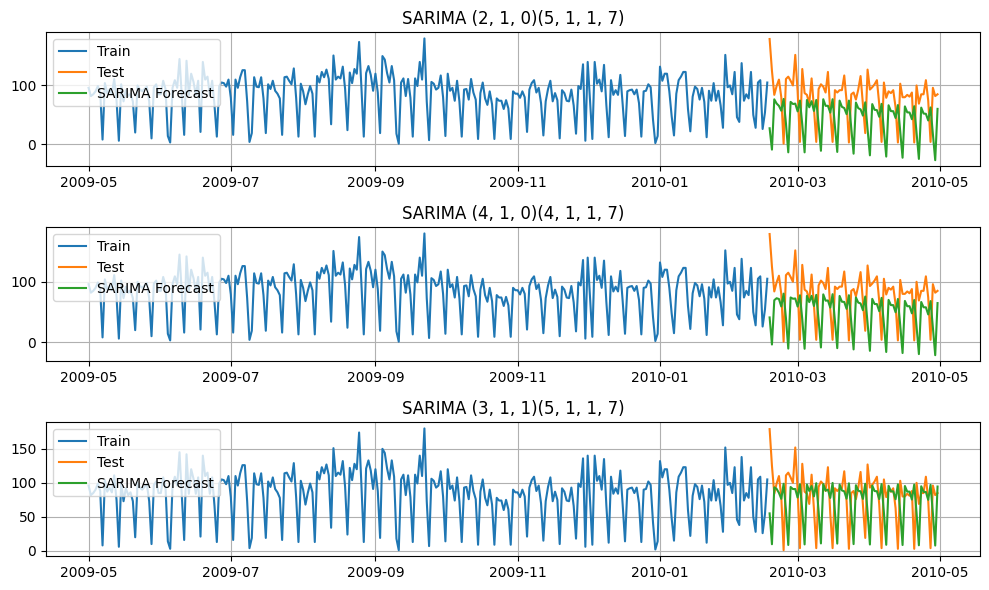

In [42]:
#| echo : false

# plot 3,1 format
fig, (ax1,ax2,ax3) = plt.subplots(3,1) 

ax1.plot(train.index, train['Cash'], label='Train') 
ax1.plot(test.index, test['Cash'], label='Test') 
ax1.plot(test.index, forecast_sarima_1, label='SARIMA Forecast') 
ax1.set_title(f'SARIMA {sarima_evaluation_results.Order[0]}{sarima_evaluation_results.Seasonal[0]}')
ax1.grid(True)
ax1.legend(loc='upper left')

ax2.plot(train.index, train['Cash'], label='Train') 
ax2.plot(test.index, test['Cash'], label='Test') 
ax2.plot(test.index, forecast_sarima_2, label="SARIMA Forecast") 
ax2.set_title(f'SARIMA {sarima_evaluation_results.Order[1]}{sarima_evaluation_results.Seasonal[1]}')
ax2.grid(True)
ax2.legend(loc='upper left')

ax3.plot(train.index, train['Cash'], label='Train') 
ax3.plot(test.index, test['Cash'], label='Test') 
ax3.plot(test.index, forecast_sarima_3, label='SARIMA Forecast') 
ax3.set_title(f'SARIMA {sarima_evaluation_results.Order[2]}{sarima_evaluation_results.Seasonal[2]}')
ax3.grid(True)
ax3.legend(loc='upper left')

plt.tight_layout()

plt.show()

#### Exponential Smoothing Model

In [43]:
#| message : false
#| warning : false

exponential_smoothing_evaluation(atm1)

c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(d

,Model,MSE,RMSE,MAE
0,Holt-Winters Model,895.941867,29.051460,22.192532
1,Simple Exponential Smoothing,1399.418173,37.187810,28.825951
2,Holt's Linear Trend Model,4113.313636,59.591352,50.296664


In [44]:
#| warning : false
#| message : false

# simple exponential smoothing
model_simple = SimpleExpSmoothing(train['Cash']).fit(optimized = True)
forecasts_simple = model_simple.forecast(len(test))

# Holt model
model_holt = Holt(train['Cash'], damped_trend=True).fit(optimized = True)
forecasts_holt = model_holt.forecast(len(test))

# Holt Winters model
model_holt_winters =  ExponentialSmoothing(train['Cash'], trend='mul', seasonal='mul', seasonal_periods=7).fit(optimized = True)
forecasts_holt_winters = model_holt_winters.forecast(len(test)) 

c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


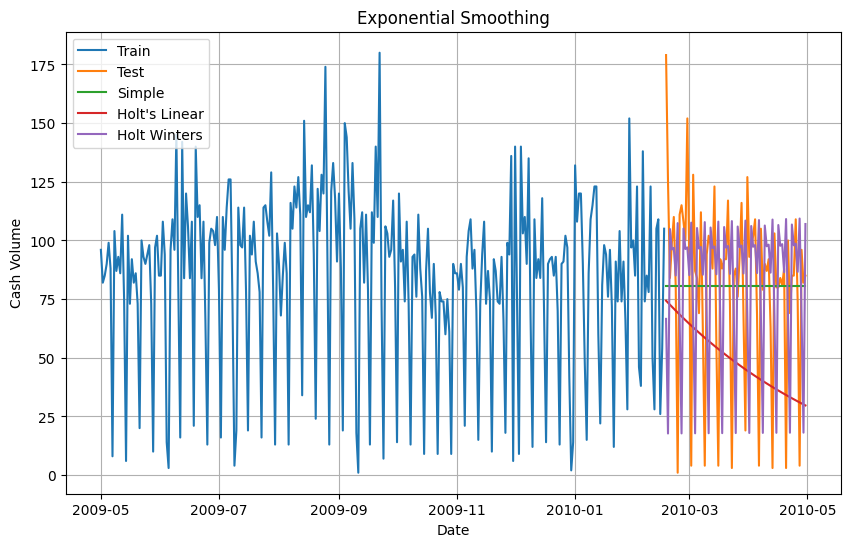

In [45]:
plot_func(forecasts_simple, forecasts_holt, forecasts_holt_winters, 'Exponential Smoothing')

For ATM 1, SARIMA(3,1,1)[5,1,1,7] had lower MSE and MAE than the Holt-Winter Model so we weill choose this model to forecast the value for May 2010. Although, this SARIMA model had the highest AIC and BIC value means that it has the worse fit on the data but had the better predictive capabilites.

### Models for ATM2

In [46]:
#| warning : false
#| message : false

atm2.drop('ATM', inplace=True, axis=1)

C:\Users\nickc\AppData\Local\Temp\ipykernel_34840\3566812016.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm2.drop('ATM', inplace=True, axis=1)


In [47]:
n = int(len(atm2) * 0.8 )

train2, test2 = atm2.iloc[:n], atm2.iloc[n:]

In [48]:
#| message : false
#| warning : false

atm2_sarima = arima_model_evaluation(atm2)
atm2_sarima

,Model,Order,Seasonal,MSE,RMSE,MAE,AIC,BIC
0,SARIMA 1,"(1, 1, 0)","(4, 1, 0, 7)",576.897519,24.018691,17.326372,654.157756,667.204079
1,SARIMA 2,"(2, 1, 0)","(5, 1, 1, 7)",787.412224,28.060866,22.229745,1335.590368,1361.935651
2,SARIMA 3,"(2, 1, 0)","(5, 1, 2, 7)",494.783992,22.243741,15.982527,1993.953925,2027.472507


In [49]:
#| warning : false
#| message : false


# forecast sarima models on test
sarima_1 = SARIMAX(train['Cash'],order = atm2_sarima.Order[0], seasonal_order= atm2_sarima.Seasonal[0]).fit()
forecast_sarima_1 = sarima_1.forecast(steps=len(test))

sarima_2 = SARIMAX(train['Cash'],order = atm2_sarima.Order[1], seasonal_order= atm2_sarima.Seasonal[1]).fit()
forecast_sarima_2 = sarima_2.forecast(steps=len(test))

sarima_3 = SARIMAX(train['Cash'],order = atm2_sarima.Order[2], seasonal_order= atm2_sarima.Seasonal[2]).fit()
forecast_sarima_3 = sarima_3.forecast(steps=len(test))

c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so in

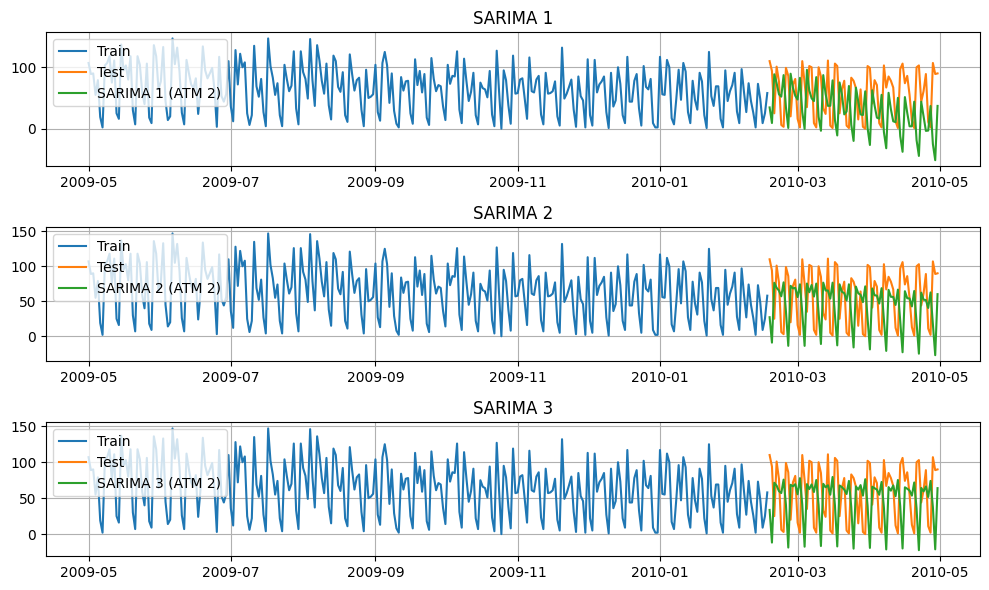

In [50]:
#| echo : false

fig, (ax1,ax2,ax3) = plt.subplots(3,1) 

ax1.plot(train2.index, train2['Cash'], label='Train') 
ax1.plot(test2.index, test2['Cash'], label='Test') 
ax1.plot(test2.index, forecast_sarima_1, label='SARIMA 1 (ATM 2)') 
ax1.set_title('SARIMA 1')
ax1.grid(True)
ax1.legend(loc='upper left')

ax2.plot(train2.index, train2['Cash'], label='Train') 
ax2.plot(test2.index, test2['Cash'], label='Test') 
ax2.plot(test2.index, forecast_sarima_2, label='SARIMA 2 (ATM 2)') 
ax2.set_title('SARIMA 2')
ax2.grid(True)
ax2.legend(loc='upper left')

ax3.plot(train2.index, train2['Cash'], label='Train') 
ax3.plot(test2.index, test2['Cash'], label='Test') 
ax3.plot(test2.index, forecast_sarima_3, label='SARIMA 3 (ATM 2)') 
ax3.set_title('SARIMA 3')
ax3.grid(True)
ax3.legend(loc='upper left')

plt.tight_layout()

plt.show()

#### Exponential Smoothing

In [51]:
#| message : false
#| warning : false

atm2['Cash'] = atm2['Cash'] + 0.00001

C:\Users\nickc\AppData\Local\Temp\ipykernel_34840\4286002323.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm2['Cash'] = atm2['Cash'] + 0.00001


In [52]:
#| message : false
#| warning : false

exponential_smoothing_evaluation(atm2)

c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(d

,Model,MSE,RMSE,MAE
0,Simple Exponential Smoothing,1399.765170,37.280527,30.952114
1,Holt-Winters Model,6629.236655,53.926247,41.874426
2,Holt's Linear Trend Model,7194.761476,77.956114,66.620276


In [53]:
#| message : false
#| warning : false
#| echo : false

# simple exponential smoothing
model_simple = SimpleExpSmoothing(train['Cash']).fit(optimized = True)
forecasts_simple = model_simple.forecast(len(test))

# Holt model
model_holt = Holt(train['Cash'], exponential=False, damped_trend=True).fit(optimized = True)
forecasts_holt = model_holt.forecast(len(test))

# Holt Winters model
model_holt_winters =  ExponentialSmoothing(train['Cash'] + 0.0001, trend='mul', seasonal='mul', seasonal_periods=7, use_boxcox=True,freq='D').fit(optimized = True)
forecasts_holt_winters = model_holt_winters.forecast(len(test)) 

c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


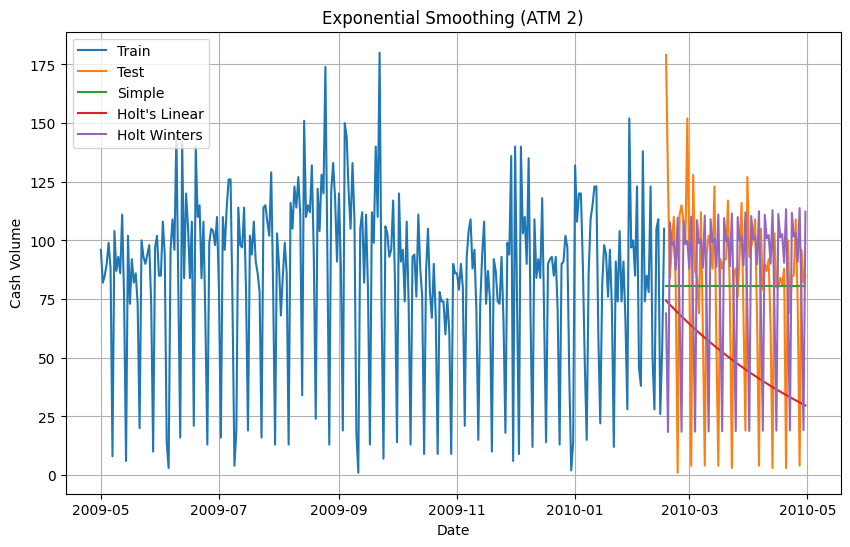

In [54]:
plot_func(forecasts_simple, forecasts_holt, forecasts_holt_winters, 'Exponential Smoothing (ATM 2)')

For ATM2, SARIMA(2,1,0)[5,1,2,7] has the lowest error values among the SARIMA models but has the high AIC and BIC values similar to ATM1's SARIMA models. As for the Holt-winter models, it has higher error scores compared to the SARIMA model. Therefore, we will choose SARIMA(2,1,0)[5,1,2,7] to forecast MAy 2010.

### Models for ATM3

In [55]:
#| message : false
#| warning : false

atm3.drop('ATM', inplace=True, axis = 1)

C:\Users\nickc\AppData\Local\Temp\ipykernel_34840\12418884.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm3.drop('ATM', inplace=True, axis = 1)


In [98]:
#| message : false 
#| warning : false

naive = SimpleExpSmoothing(atm3['Cash']).fit(optimized = True)
forecasts_simple = naive.forecast(31)

c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


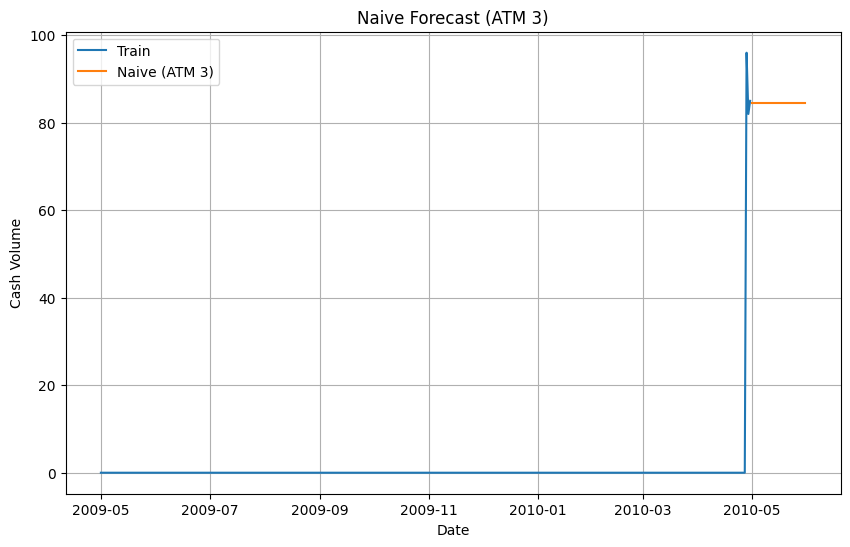

In [57]:
fig, ax = plt.subplots() 

ax.plot(atm3.index, atm3['Cash'], label='Train')  
ax.plot(forecasts_simple.index, forecasts_simple, label='Naive (ATM 3)') 

ax.set_title("Naive Forecast (ATM 3)")
ax.set_xlabel('Date')
ax.set_ylabel('Cash Volume')
ax.grid(True) 
ax.legend(loc = 'upper left')

plt.show()

### Models for ATM 4

#### SARIMA Model

In [58]:
#| message : false
#| warning : false
atm4.drop('ATM', inplace =True, axis =1)

C:\Users\nickc\AppData\Local\Temp\ipykernel_34840\2273025736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm4.drop('ATM', inplace =True, axis =1)


In [59]:
#| message : false
#| warning : false
atm4_arima = arima_model_evaluation(np.log(atm4))
atm4_arima

,Model,Order,Seasonal,MSE,RMSE,MAE,AIC,BIC
0,SARIMA 1,"(2, 1, 0)","(5, 1, 0, 7)",1.687952,1.299212,0.905301,247.424311,264.819409
1,SARIMA 2,"(3, 1, 0)","(5, 1, 0, 7)",3.599405,1.897210,1.366051,482.766889,509.112172
2,SARIMA 3,"(4, 1, 0)","(4, 1, 1, 7)",1.828468,1.352209,0.992804,732.365713,765.884294


In [60]:
#| echo : false
# train -test split 

n = int(len(atm4) * 0.8)

train4, test4 = atm4.iloc[:n], atm4.iloc[n:]

train4 = np.log(train4)

In [61]:
#| warning : false
#| message : false


# forecast sarima models on test
sarima_1 = SARIMAX(train4['Cash'],order = atm4_arima.Order[0], seasonal_order= atm4_arima.Seasonal[0]).fit()
forecast_sarima_1 = sarima_1.forecast(steps=len(test4))

sarima_2 = SARIMAX(train4['Cash'],order = atm4_arima.Order[1], seasonal_order= atm4_arima.Seasonal[1]).fit()
forecast_sarima_2 = sarima_2.forecast(steps=len(test4))

sarima_3 = SARIMAX(train4['Cash'],order = atm4_arima.Order[2], seasonal_order= atm4_arima.Seasonal[2]).fit()
forecast_sarima_3 = sarima_3.forecast(steps=len(test4))

c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so in

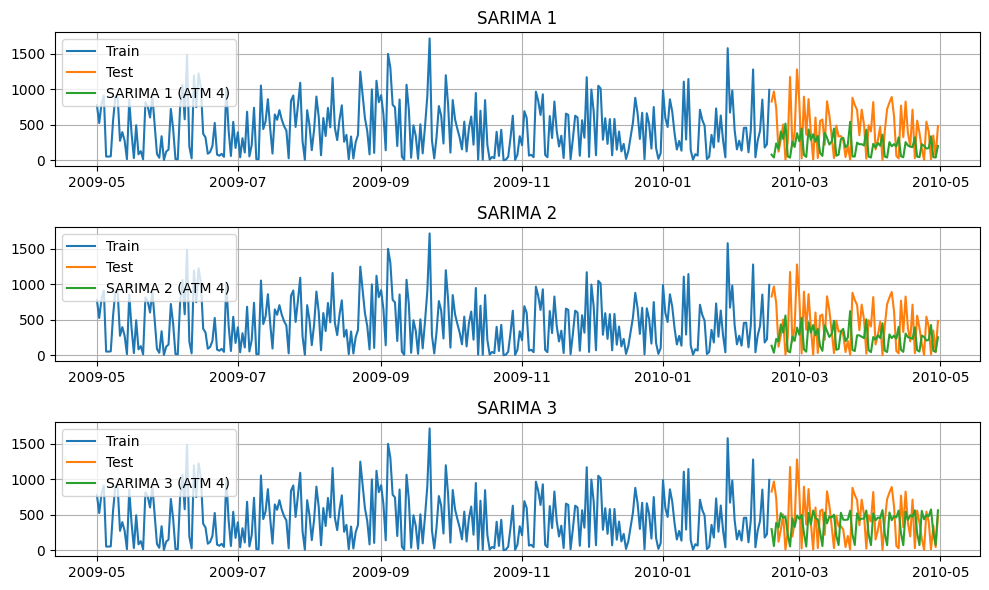

In [62]:
#| echo : false

fig, (ax1,ax2,ax3) = plt.subplots(3,1) 

ax1.plot(train4.index, np.exp(train4['Cash']), label='Train') 
ax1.plot(test4.index, test4['Cash'], label='Test') 
ax1.plot(test4.index, np.exp(forecast_sarima_1), label='SARIMA 1 (ATM 4)') 
ax1.set_title('SARIMA 1')
ax1.grid(True)
ax1.legend(loc='upper left')

ax2.plot(train4.index, np.exp(train4['Cash']), label='Train') 
ax2.plot(test4.index, test4['Cash'], label='Test') 
ax2.plot(test4.index, np.exp(forecast_sarima_2), label='SARIMA 2 (ATM 4)') 
ax2.set_title('SARIMA 2')
ax2.grid(True)
ax2.legend(loc='upper left')

ax3.plot(train4.index, np.exp(train4['Cash']), label='Train') 
ax3.plot(test4.index, test4['Cash'], label='Test') 
ax3.plot(test4.index, np.exp(forecast_sarima_3), label='SARIMA 3 (ATM 4)') 
ax3.set_title('SARIMA 3')
ax3.grid(True)
ax3.legend(loc='upper left')

plt.tight_layout()

plt.show()

#### Exponential Smoothing 

In [63]:
#| message : false
#| warning : false

exponential_smoothing_evaluation(np.log(atm4))

c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so in

,Model,MSE,RMSE,MAE
0,Holt-Winters Model,1.526018,1.205354,0.893124
1,Simple Exponential Smoothing,1.830632,1.340985,1.085312
2,Holt's Linear Trend Model,2.563454,1.581905,1.302244


In [64]:
#| message : false
#| warning : false

# simple exponential smoothing
model_simple = SimpleExpSmoothing(train4['Cash']).fit(optimized = True)
forecasts_simple = model_simple.forecast(len(test4))

# Holt model
model_holt = Holt(train4['Cash'], exponential=False, damped_trend=True).fit(optimized = True)
forecasts_holt = model_holt.forecast(len(test4))

# Holt Winters model
model_holt_winters =  ExponentialSmoothing(train4['Cash'] + 0.0001, trend='mul', seasonal='mul', seasonal_periods=7, use_boxcox=True,freq='D').fit(optimized = True)
forecasts_holt_winters = model_holt_winters.forecast(len(test4)) 


c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


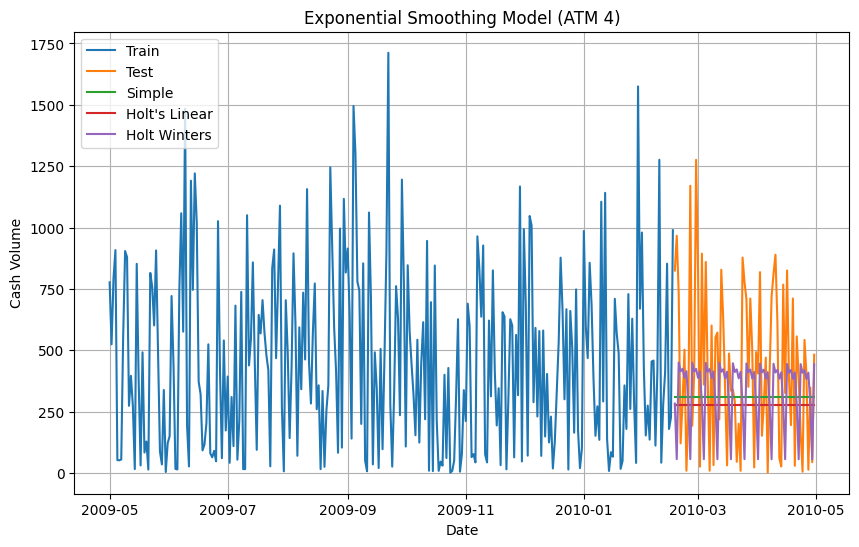

In [65]:

#| echo : false

fig, ax = plt.subplots() 

ax.plot(train4.index, np.exp(train4['Cash']), label='Train') 
ax.plot(test4.index, test4['Cash'], label='Test') 
ax.plot(test4.index, np.exp(forecasts_simple), label='Simple') 
ax.plot(test4.index, np.exp(forecasts_holt), label="Holt's Linear") 
ax.plot(test4.index, np.exp(forecasts_holt_winters), label='Holt Winters') 

ax.set_title('Exponential Smoothing Model (ATM 4)')
ax.set_xlabel('Date')
ax.set_ylabel('Cash Volume')
ax.grid(True) 
ax.legend(loc = 'upper left')

plt.show()

ATM4 data, we had the most trouble with this data since our models are a difficult time capture the nature of this data. We tried multiple different power transformations. At the end using the log() transform gave us the best model in terms of MSE, RMSE and MAE. 

We chose the Holt-Winter Model to forecast May 2010 since it had marginal better performance metrics compared to the SARIMA models. Even with cross validation to find the optimal paratameters for the SARIMA model, the Holt- Winters model performed better on average.

## Forecasting

ATM1 Model : SARIMA(3,1,1)[5,1,1,7]

ATM2 Model : SARIMA(2,1,0)[5,1,2,7]

ATM3 Model : Naive Model 

ATM4 Model : Holt-Winters Model

Forecast 31 time steps out of the sample since May 2010 has 31 days.

In [100]:
#| message : false
#| warning : false

sarima_atm1 = SARIMAX(atm1,order = (3,1,1), seasonal_order= (5,1,1,7)).fit()
atm1_may_forecast = sarima_atm1.forecast(steps = 31)
df_atm1_may_forecast = pd.DataFrame(atm1_may_forecast.values, index = atm1_may_forecast.index, columns=['ATM1_Cash'])

sarima_atm2 = SARIMAX(atm2,order = (2,1,0), seasonal_order= (5,1,2,7)).fit()
atm2_may_forecast = sarima_atm2.forecast(steps = 31)
df_atm2_may_forecast = pd.DataFrame(atm2_may_forecast.values, index = atm2_may_forecast.index, columns=['ATM2_Cash'])

df_atm3_may_forecast = pd.DataFrame(forecasts_simple, index=forecasts_simple.index, columns=['ATM3_Cash'])

atm4_exp_smoothing = ExponentialSmoothing(atm4 + 0.0001, trend='mul', seasonal='mul', seasonal_periods=7, use_boxcox=True,freq='D').fit(optimized = True)
atm4_may_forecast = atm4_exp_smoothing.forecast(steps=31) 
df_atm4_may_forecast = pd.DataFrame(atm4_may_forecast.values, index = atm4_may_forecast.index, columns=['ATM4_Cash'])

c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [101]:
# combine df then convert to excel file
ATM_May_2010_Forecast = pd.concat([df_atm1_may_forecast, df_atm2_may_forecast, df_atm3_may_forecast, df_atm4_may_forecast], axis =1)


In [102]:
ATM_May_2010_Forecast.head(10)

,ATM1_Cash,ATM2_Cash,ATM3_Cash,ATM4_Cash
2010-05-01,87.260218,83.511000,84.583268,315.545928
2010-05-02,103.136107,79.893254,84.583268,374.189242
2010-05-03,74.655395,24.993649,84.583268,381.475684
2010-05-04,5.095556,11.059144,84.583268,103.213073
2010-05-05,100.947659,111.359809,84.583268,412.473105
2010-05-06,80.677599,101.626487,84.583268,263.181331
2010-05-07,86.071730,82.463012,84.583268,485.602857
2010-05-08,88.694439,92.153548,84.583268,314.049229
2010-05-09,102.555986,92.310069,84.583268,372.403160
2010-05-10,72.257999,32.725390,84.583268,379.653581


In [103]:
ATM_May_2010_Forecast = ATM_May_2010_Forecast.reset_index()
ATM_May_2010_Forecast  = ATM_May_2010_Forecast.rename(columns={'index':'Date'})

In [104]:
ATM_May_2010_Forecast.to_excel('ATM_MAy_2010_Forecast.xlsx')

___

# Part B : Power Data

## EDA and Data Wrangling 

In [71]:
#| message : false
#| warning : false

power_df = pd.read_excel('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/project_1/data_files/ResidentialCustomerForecastLoad-624.xlsx', parse_dates=['YYYY-MMM'], index_col = 'YYYY-MMM')
power_df

C:\Users\nickc\AppData\Local\Temp\ipykernel_34840\2677133874.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  power_df = pd.read_excel('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/project_1/data_files/ResidentialCustomerForecastLoad-624.xlsx', parse_dates=['YYYY-MMM'], index_col = 'YYYY-MMM')


,CaseSequence,KWH
YYYY-MMM,,
1998-01-01,733,6862583.0
1998-02-01,734,5838198.0
1998-03-01,735,5420658.0
1998-04-01,736,5010364.0
1998-05-01,737,4665377.0
...,...,...
2013-08-01,920,9080226.0
2013-09-01,921,7968220.0
2013-10-01,922,5759367.0


Removing `CaseSequence` since it will be helpful for forecasting.

In [72]:
power_df = power_df[['KWH']]

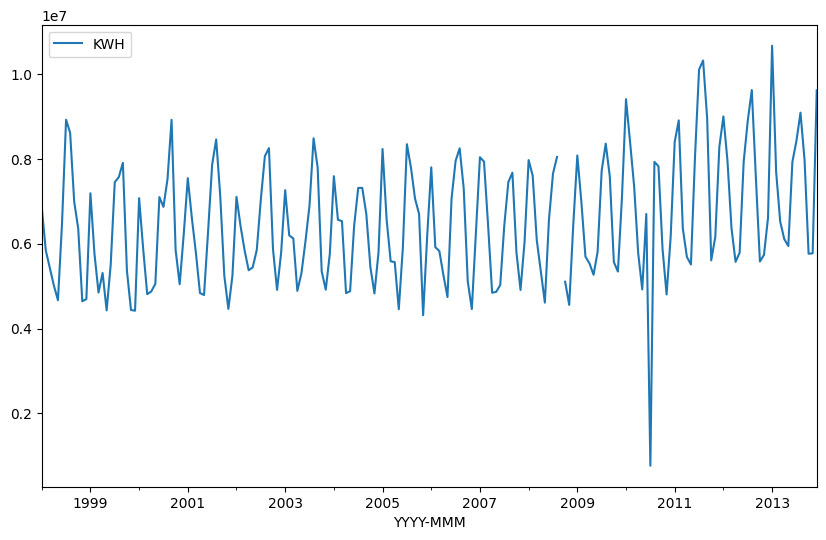

In [73]:
power_df.plot()
plt.show()

There is a gap in the time series plot between 2008 and 2009. We can check for missing value of skipped time steps. 

In [74]:
show_summary(power_df)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DIMENSIONS : (192, 1)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
COLUMNS: 

['KWH']
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATA INFO: 

KWH    float64
dtype: object
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
MISSING VALUES: 

KWH    1
dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NUMBER OF UNIQUE VALUES: 

KWH    191
dtype: int64


So, there was one missing value at September 2008. We can impute the NA values with median of the data since it more resistant to outliers. Also, replace the outlier with median.

In [75]:
power_df.index[power_df.isna().any(axis =1)]

DatetimeIndex(['2008-09-01'], dtype='datetime64[ns]', name='YYYY-MMM', freq=None)

In [76]:
power_df.loc['2010-07-01', 'KWH'] = power_df['KWH'].median()



C:\Users\nickc\AppData\Local\Temp\ipykernel_34840\2671974967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df.loc['2010-07-01', 'KWH'] = power_df['KWH'].median()


C:\Users\nickc\AppData\Local\Temp\ipykernel_34840\2979879913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df['KWH'].fillna(power_df['KWH'].median(), inplace=True)


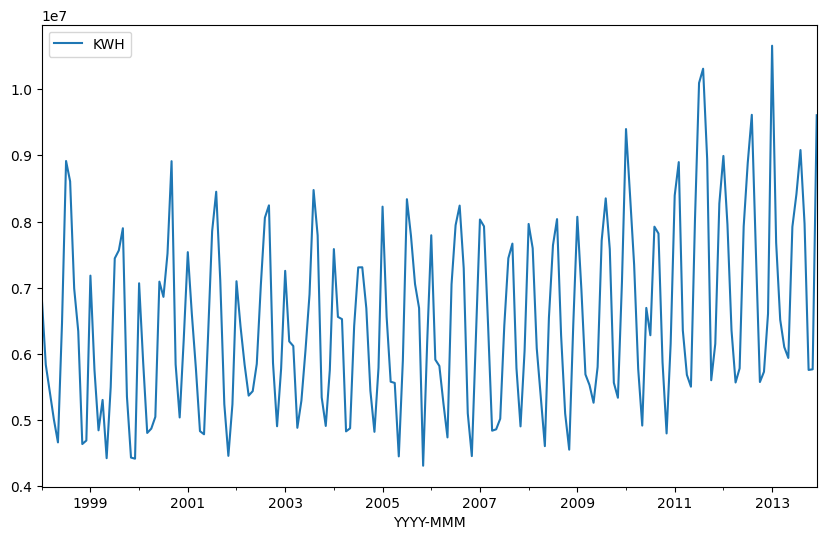

In [77]:
#| message : false
#| warning : false

power_df['KWH'].fillna(power_df['KWH'].median(), inplace=True)

power_df.plot()
plt.show()

In [78]:
adfuller_test(power_df['KWH'])

ADF Statistic: -0.259931
p-value: 0.930991
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
Result: The series is not stationary


In [79]:
adfuller_test(power_df['KWH'].diff().dropna())

ADF Statistic: -12.385605
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
Result: The series is stationary


So, the data requires differencing. After, differing it once the data becomes stationary.

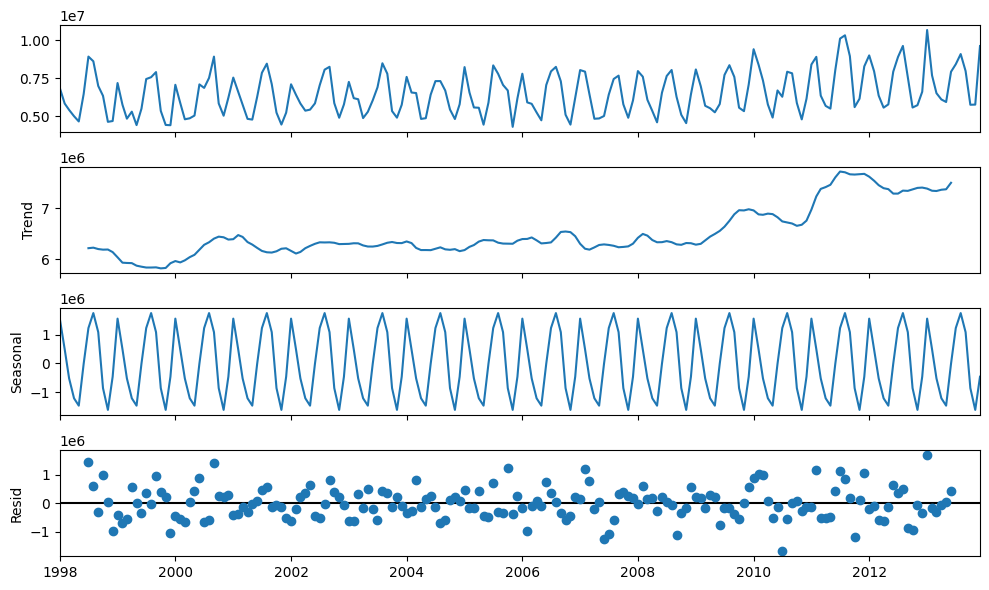

In [80]:
seasonal_decompose(power_df).plot()
plt.show()

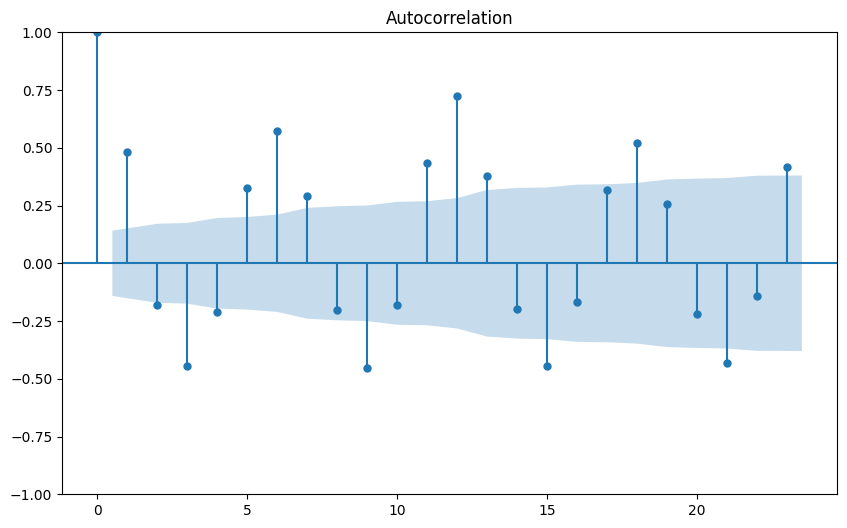

In [81]:
plot_acf(power_df['KWH'])
plt.show()

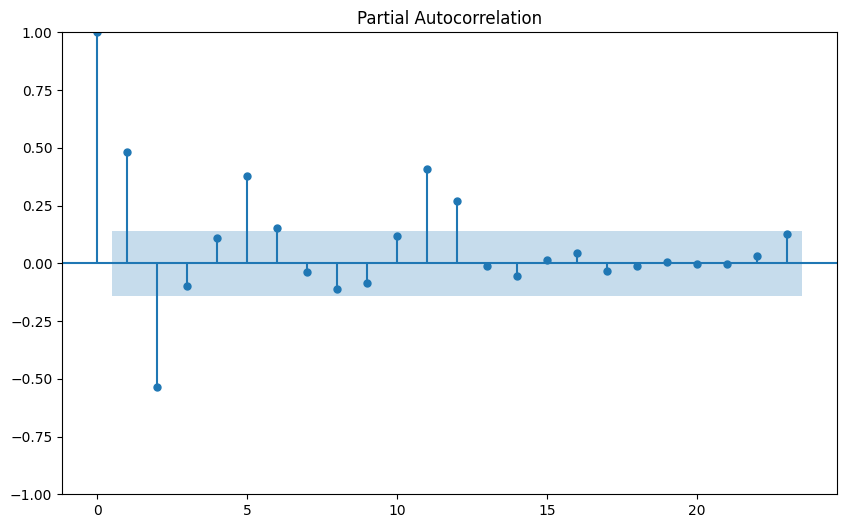

In [82]:
plot_pacf(power_df['KWH'])
plt.show()

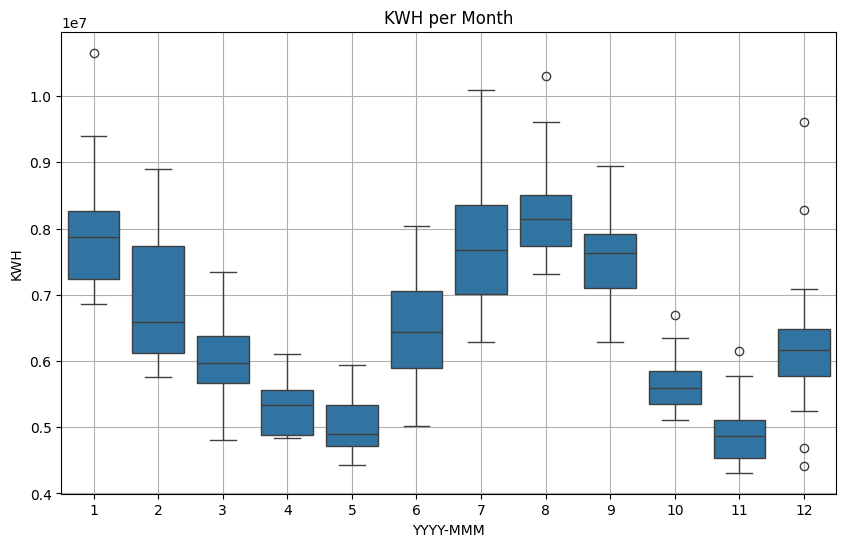

In [83]:
sns.boxplot(data = power_df, x = power_df.index.month, y = 'KWH')
plt.title('KWH per Month')
plt.grid(True)
plt.show()


Based on the boxplot, power consumption peaks during the summer and winter months where residents are using the their power on AC units in the summer and heating in the winter. 

In [84]:
power_df.describe().T


,count,mean,std,min,25%,50%,75%,max
KWH,192.0,6.530046e+06,1.382828e+06,4313019.0,5443502.5,6283324.0,7608791.75,10655730.0


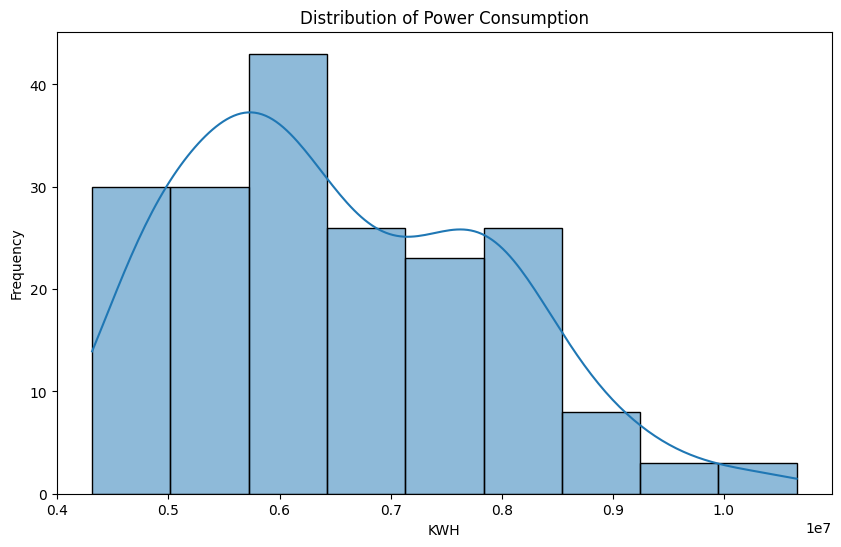

In [85]:
sns.histplot(data=power_df, x='KWH', kde=True)
plt.title('Distribution of Power Consumption')
plt.xlabel('KWH')
plt.ylabel('Frequency')
plt.show()

`power_df` is centered around 0.6 KWH for the past 15 years of recorded data.

## Model Building and Selection

Using the SARIMA and Exponential Smoothing techniques for forecasting. 

### SARIMA Models

In [86]:
power_sarima = arima_model_evaluation(power_df['KWH'], m =12, D = 0)
power_sarima

,Model,Order,Seasonal,MSE,RMSE,MAE,AIC,BIC
0,SARIMA 1,"(0, 1, 0)","(1, 0, 0, 12)",1.199599e+12,1.095262e+06,958391.377650,1163.163395,1166.438568
1,SARIMA 2,"(2, 1, 2)","(1, 0, 1, 12)",7.846986e+11,8.858321e+05,688698.541995,2297.379262,2313.694395
2,SARIMA 3,"(2, 1, 2)","(1, 0, 1, 12)",4.982655e+11,7.058792e+05,554137.035650,3440.197793,3459.351182


SARIMA is able to predict new data well while not overfitting the model on the training data.

In [87]:
train_power, test_power = power_df.iloc[:int(len(power_df) * 0.8)],power_df.iloc[int(len(power_df) * 0.8):]

In [88]:
#| message : false
#| warning : false

# forecast sarima models on test
sarima = SARIMAX(train_power['KWH'],order = power_sarima.Order[2], seasonal_order= power_sarima.Seasonal[2]).fit()
forecast_power = sarima.forecast(steps=len(test_power))


c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


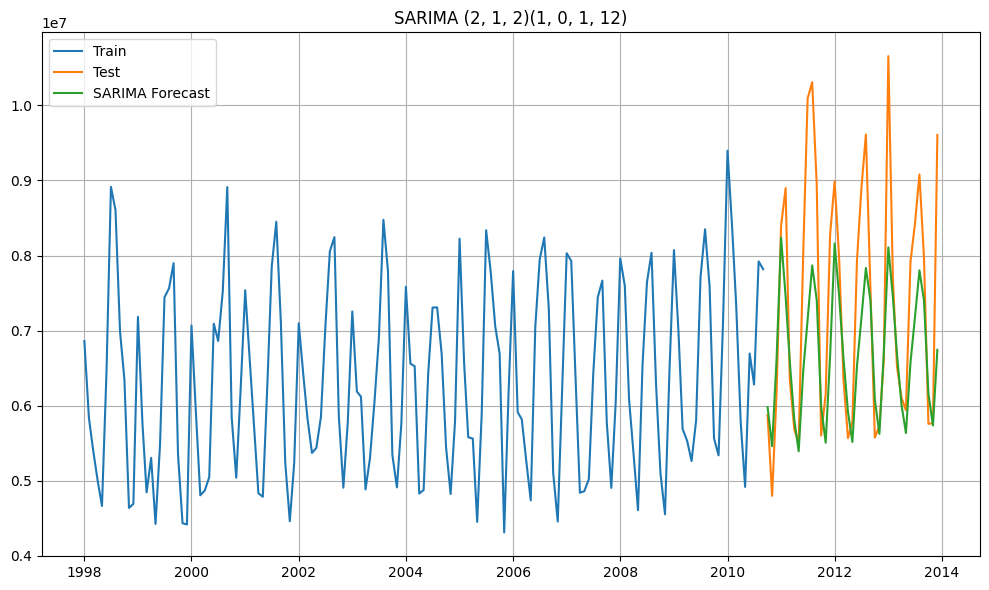

In [89]:
fig, ax1 = plt.subplots() 

ax1.plot(train_power.index, train_power['KWH'], label='Train') 
ax1.plot(test_power.index, test_power['KWH'], label='Test') 
ax1.plot(test_power.index, forecast_power, label='SARIMA Forecast') 
ax1.set_title(f'SARIMA {power_sarima.Order[2]}{power_sarima.Seasonal[2]}')
ax1.grid(True)
ax1.legend(loc='upper left')
plt.tight_layout()

plt.show()

## Exponential Smoothing

In [90]:
#| message : false
#| warning : false
#| echo : false

power_exp = exponential_smoothing_evaluation(power_df['KWH'])
power_exp

c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, 

,Model,MSE,RMSE,MAE
0,Simple Exponential Smoothing,1.986510e+12,1.390061e+06,1.152736e+06
1,Holt-Winters Model,2.894206e+12,1.652054e+06,1.377027e+06
2,Holt's Linear Trend Model,7.132355e+12,2.529641e+06,2.254770e+06


c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, 

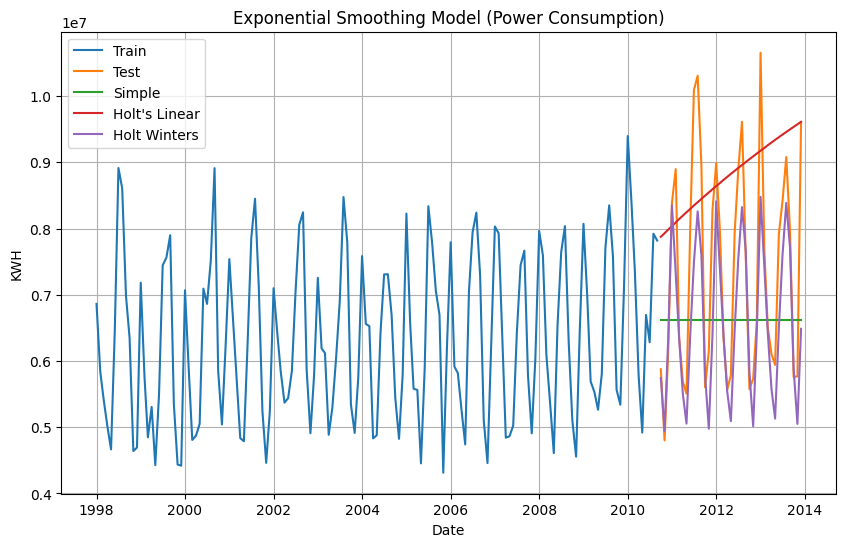

In [91]:
#| message : false
#| warning : false


# simple exponential smoothing
model_simple = SimpleExpSmoothing(train_power['KWH']).fit(optimized = True)
forecasts_simple = model_simple.forecast(len(test_power))

# Holt model
model_holt = Holt(train_power['KWH'], exponential=False, damped_trend=True).fit(optimized = True)
forecasts_holt = model_holt.forecast(len(test_power))

# Holt Winters model
model_holt_winters =  ExponentialSmoothing(train_power['KWH'] + 0.0001, trend='mul', seasonal='mul', seasonal_periods=12, use_boxcox=True).fit(optimized = True)
forecasts_holt_winters = model_holt_winters.forecast(len(test_power)) 

fig, ax = plt.subplots() 

ax.plot(train_power.index, train_power['KWH'], label='Train') 
ax.plot(test_power.index, test_power['KWH'], label='Test') 
ax.plot(test_power.index, forecasts_simple, label='Simple') 
ax.plot(test_power.index, forecasts_holt, label="Holt's Linear") 
ax.plot(test_power.index, forecasts_holt_winters, label='Holt Winters') 

ax.set_title('Exponential Smoothing Model (Power Consumption)')
ax.set_xlabel('Date')
ax.set_ylabel('KWH')
ax.grid(True) 
ax.legend(loc = 'upper left')

plt.show()

We will use the Holt-Winters model since it captures the variability of the data bettter then the SARIMA model.

In [92]:
power_model = ExponentialSmoothing(power_df['KWH'] + 0.0001, trend='mul', seasonal='mul', seasonal_periods=12, use_boxcox=True).fit(optimized = True)
power_forecasts_holt_winters = power_model.forecast(12) # 12 time steps

c:\Users\nickc\DataScience\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [93]:
df_power_forecasts_holt_winters = pd.DataFrame(power_forecasts_holt_winters.values, index = power_forecasts_holt_winters.index, columns = ['KWH'])
df_power_forecasts_holt_winters

,KWH
2014-01-01,1.005065e+07
2014-02-01,8.596080e+06
2014-03-01,7.051000e+06
2014-04-01,6.238878e+06
2014-05-01,5.960655e+06
2014-06-01,7.953689e+06
2014-07-01,9.103111e+06
2014-08-01,9.955047e+06
2014-09-01,8.742001e+06
2014-10-01,6.326984e+06


In [94]:
df_power_forecasts_holt_winters.to_excel('Power_Forecasts.xlsx', index = False)

___

# Appendix

In [95]:
# repeat function each ATM to maKE  SARIMA models
def arima_model_evaluation(df: pd.DataFrame, size: float = 0.8, m = 7, D =1) -> None:

    train_size = int(len(df) * size)
    train, test = df[:train_size], df[train_size:]

    tscv = TimeSeriesSplit(n_splits=3) 
    # cross validation : approach Rolling window. test data must always be the future data from the training set. why? prevents data leakage

    mse_list = []
    rmse_list = []
    mae_list = []
    order_list = []
    seasonal_order_list = []
    aic_list = []
    bic_list = []
    
    for train_index, val_index in tscv.split(train):

        train_data, val_data = train.iloc[train_index], train.iloc[val_index]

        model = auto_arima(train_data, 
                            start_p = 0,
                            start_q = 0,
                            max_p = 10,
                            max_q = 10,
                            d = 1,
                            seasonal=True, 
                            start_P = 0,
                            start_Q = 0,
                            max_P = 5,
                            max_Q = 5,
                            max_order = None, # removes limit of p+q+P+Q
                            m = m, 
                            D = D,
                            stepwise = True,
                            error_action = 'ignore',
                            scoring = 'mse')
  
        predictions = model.predict(len(val_data)) # same size as test data

        mse = mean_squared_error(val_data, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(val_data, predictions)

        order_list.append(model.order)
        seasonal_order_list.append(model.seasonal_order)
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        aic_list.append(model.aic())
        bic_list.append(model.bic())

    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    avg_mae = np.mean(mae_list)


    evaluation_df = pd.DataFrame({
        'Model': ['SARIMA 1', 'SARIMA 2', 'SARIMA 3'],
        'Order' : order_list,
        'Seasonal' : seasonal_order_list,
        'MSE': mse_list,
        'RMSE': rmse_list,
        'MAE': mae_list,
        'AIC': aic_list,
        'BIC' : bic_list
    })



    return evaluation_df


In [96]:

def exponential_smoothing_evaluation(df: pd.DataFrame, size: float = 0.8) -> None: 
    # defualt it to 0.8
    train_size = int(len(df) * size)
    train, test = df[:train_size], df[train_size:]

    models = []
    mse_values = []
    rmse_values = []
    mae_values = []

    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(train):
        train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]

        # simple exp model
        model_ses = SimpleExpSmoothing(train_cv).fit(optimized=True)
        forecast_ses = model_ses.forecast(len(test_cv))
        mse_ses = mean_squared_error(test_cv, forecast_ses)
        rmse_ses = np.sqrt(mse_ses)
        mae_ses = mean_absolute_error(test_cv, forecast_ses)

        # holt model
        model_holt = Holt(train_cv).fit(optimized=True)
        forecast_holt = model_holt.forecast(len(test_cv))
        mse_holt = mean_squared_error(test_cv, forecast_holt)
        rmse_holt = np.sqrt(mse_holt)
        mae_holt = mean_absolute_error(test_cv, forecast_holt)

        # holt winters model
        model_hw = ExponentialSmoothing(train_cv, 
                                        seasonal_periods=7, 
                                        trend='mul', 
                                        seasonal='mul').fit(optimized=True)
                                        
        forecast_hw = model_hw.forecast(len(test_cv))
        mse_hw = mean_squared_error(test_cv, forecast_hw)
        rmse_hw = np.sqrt(mse_hw)
        mae_hw = mean_absolute_error(test_cv, forecast_hw)

        # add it to the empty lists
        models.extend(['Simple Exponential Smoothing', 'Holt\'s Linear Trend Model', 'Holt-Winters Model'])
        mse_values.extend([mse_ses, mse_holt, mse_hw])
        rmse_values.extend([rmse_ses, rmse_holt, rmse_hw])
        mae_values.extend([mae_ses, mae_holt, mae_hw])

    evaluation_results = pd.DataFrame({'Model': models, 
                                        'MSE': mse_values, 
                                        'RMSE': rmse_values, 
                                        'MAE': mae_values})

    # groupby models then agg mena
    average_metrics = evaluation_results.groupby('Model').mean().sort_values('MSE', ascending = True).reset_index()

    return average_metrics


In [97]:

def plot_func(forecast1: list[float],
              forecast2: list[float],
              forecast3: list[float],
              title: str) -> None:
    """Function to plot the forecasts."""
    fig, ax = plt.subplots() 

    ax.plot(train.index, train['Cash'], label='Train') 
    ax.plot(test.index, test['Cash'], label='Test') 
    ax.plot(test.index, forecast1, label='Simple') 
    ax.plot(test.index, forecast2, label="Holt's Linear") 
    ax.plot(test.index, forecast3, label='Holt Winters') 

    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cash Volume')
    ax.grid(True) 
    ax.legend(loc = 'upper left')

    plt.show()